#**Sentiment Analysis on code mixed telugu-english Sentenced using BERT**

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Step 1: Load and Parse the Text File
file_path = "codemix_sentiment_data.txt"
with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

data = []
for line in lines:
    if line.strip() == "" or ":" not in line:
        continue
    match = re.match(r"(POS|NEG|NTL):\s*(.+)", line.strip())
    if match:
        label, text = match.groups()
        data.append({"text": text.strip(), "label": label})


In [ ]:
df = pd.DataFrame(data)
label_map = {"NEG": 0, "NTL": 1, "POS": 2}
df["label"] = df["label"].map(label_map)

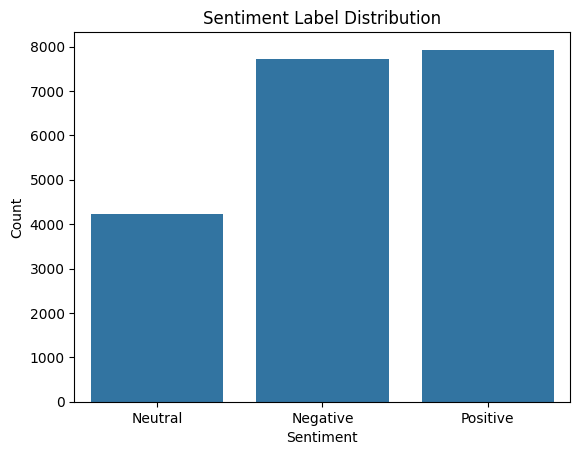

In [ ]:

# 📊 Visualization 1: Label Distribution
label_names = {0: "Negative", 1: "Neutral", 2: "Positive"}
df["label_name"] = df["label"].map(label_names)
sns.countplot(x="label_name", data=df)
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:

# Step 2: Convert to Hugging Face Dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
# Step 3: Load Tokenizer and Tokenize
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
# Step 4: Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"  # prevent logging to external services
)

Map:   0%|          | 0/17881 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Map:   0%|          | 0/1987 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro"),
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-10-1377821198.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Step 5: Train and Save
trainer.train()
eval_results = trainer.evaluate()
model.save_pretrained("sentiment_model")
tokenizer.save_pretrained("sentiment_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.558500,0.588492,0.741822,0.727130
2,0.438500,0.502301,0.785606,0.771930
3,0.397900,0.486304,0.806241,0.786969


('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/spiece.model',
 'sentiment_model/added_tokens.json',
 'sentiment_model/tokenizer.json')

In [ ]:
eval_results

{'eval_loss': 0.48630374670028687,
 'eval_accuracy': 0.8062405636638148,
 'eval_f1_macro': 0.7869689988116756,
 'eval_runtime': 13.6544,
 'eval_samples_per_second': 145.521,
 'eval_steps_per_second': 9.155,
 'epoch': 3.0}

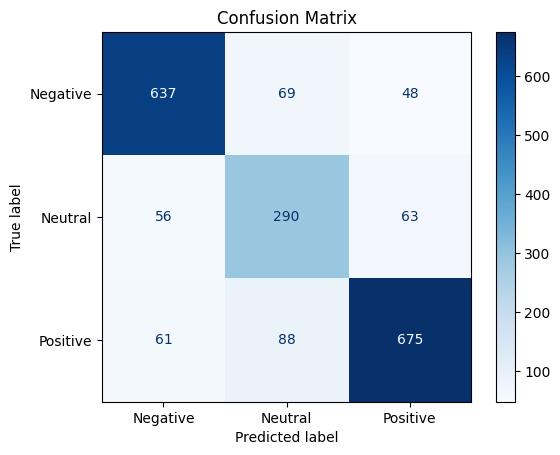

In [ ]:
# 📊 Visualization 2: Confusion Matrix
# Inference on test set
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Step 6: Inference on Multiple Code-Mixed Sentences
sentiment_pipeline = pipeline("text-classification", model="sentiment_model", tokenizer="sentiment_model")

example_sentences = [
    # Positive
    "Movie chala bagundi bro, visuals are amazing!",
    "RCB team super ga aadindi today 👏",
    "Nuvvu cheppina song naku chala nachindi ❤️",
    "Chaala clean and funny movie, recommended to everyone.",
    "Super acting by the hero! Full goosebumps moment 🔥",

    # Negative
    "Worst movie I have seen in years, total time waste.",
    "Idhi review aa? chala chetta ga undi bro.",
    "E roju service chala poor ga undi, staff respond cheyyaledu.",
    "Nuv cheppina app lo bugs ekkuva, totally disappointed.",
    "Dislike this actor’s performance – emotion ledu at all.",

    # Neutral
    "Movie release date is next Friday.",
    "RCB vs MI match starts at 7:30 PM.",
    "I watched the trailer yesterday night.",
    "Class ki 10 members attend ayyaru.",
    "Andaru review chustunnaru YouTube lo.",
    "Aahaaram chaala ruchikaramgaa undi"
]

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

for sentence in example_sentences:
    result = sentiment_pipeline(sentence)[0]
    sentiment = label_map[result['label']]
    confidence = result['score']
    print(f"Text: {sentence}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {confidence:.2f})")
    print("-" * 60)


Device set to use cuda:0


Text: Movie chala bagundi bro, visuals are amazing!
Predicted Sentiment: Positive (Confidence: 0.99)
------------------------------------------------------------
Text: RCB team super ga aadindi today 👏
Predicted Sentiment: Positive (Confidence: 0.99)
------------------------------------------------------------
Text: Nuvvu cheppina song naku chala nachindi ❤️
Predicted Sentiment: Negative (Confidence: 0.54)
------------------------------------------------------------
Text: Chaala clean and funny movie, recommended to everyone.
Predicted Sentiment: Positive (Confidence: 0.98)
------------------------------------------------------------
Text: Super acting by the hero! Full goosebumps moment 🔥
Predicted Sentiment: Positive (Confidence: 0.99)
------------------------------------------------------------
Text: Worst movie I have seen in years, total time waste.
Predicted Sentiment: Negative (Confidence: 0.75)
------------------------------------------------------------
Text: Idhi review aa? c